In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Load & Examine Data

In [35]:
data = pd.read_csv("2020_Competition_Training (1).csv")
person_id = data.iloc[:, 0]
y = data.iloc[:, 1]
X = data.drop(columns=["person_id_syn", "transportation_issues"])

C:\Users\ouxin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (80,193) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [36]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69572 entries, 0 to 69571
Columns: 824 entries, src_platform_cd to submcc_rsk_chol_ind
dtypes: float64(443), int64(360), object(21)
memory usage: 437.4+ MB


### 2. Feature Selection

In [37]:
# Drop features with the same value in all rows
temp = []
for col in X.columns:
    if X[col].nunique() == 1:
        temp.append(col)
print(temp)
X = X.drop(columns=temp)

['ccsp_034_ind', 'ccsp_120_ind', 'hlth_pgm_slvrsnkr_refer_status', 'lab_hba1_c_abn_result_ind', 'med_ip_ltach_admit_ct_pmpm', 'med_ip_ltach_admit_days_pmpm', 'med_ip_maternity_admit_ct_pmpm', 'med_ip_maternity_admit_days_pmpm', 'med_ip_mhsa_admit_ct_pmpm', 'med_ip_mhsa_admit_days_pmpm', 'rev_cms_nicu_ind', 'rx_gpi2_08_pmpm_ct', 'rx_gpi2_14_pmpm_ct', 'rx_gpi2_19_pmpm_ct', 'rx_gpi2_20_pmpm_ct', 'rx_gpi2_29_pmpm_ct', 'rx_gpi2_45_pmpm_ct', 'rx_gpi2_69_pmpm_ct', 'rx_gpi2_70_pmpm_ct', 'rx_gpi2_76_pmpm_ct', 'rx_gpi2_80_pmpm_ct', 'rx_gpi2_81_pmpm_ct', 'rx_gpi2_84_pmpm_ct', 'rx_gpi2_92_pmpm_ct', 'rx_gpi2_95_pmpm_ct', 'rx_gpi2_96_pmpm_ct', 'rx_gpi2_98_pmpm_ct', 'submcc_ben_lymp_pmpm_ct', 'submcc_brn_acc_pmpm_ct', 'submcc_cad_fh/ho_pmpm_ct', 'submcc_hdz_it_i_pmpm_ct', 'submcc_hdz_surg_pmpm_ct', 'submcc_hiv_kapo_pmpm_ct', 'submcc_hiv_pcp_pmpm_ct', 'submcc_inf_men_pmpm_ct', 'submcc_neo_fh/ho_pmpm_ct', 'submcc_pre_del_pmpm_ct', 'submcc_pre_ect_pmpm_ct', 'submcc_pre_mul_pmpm_ct', 'submcc_pre_othr_pmp

In [38]:
X.shape

(69572, 729)

### 3. Missing Value

In [39]:
na = pd.read_csv("na.csv") # Methods to deal with missing values from on our discussion
na.head()

,Variable,Type
0,mabh_seg,Replace
1,cms_ma_risk_score_nbr,Numerical
2,cms_partd_ra_factor_amt,Numerical
3,cms_ra_factor_type_cd,Categorical
4,cms_risk_adj_payment_rate_a_amt,Numerical


In [40]:
X.isna().mean().sort_values(ascending=False).head(20)

hedis_ami                  0.996651
hedis_cmc_ldc_c_control    0.789571
hedis_cmc_ldc_c_screen     0.789542
cons_homstat               0.277123
cons_n2029_y               0.277109
cons_retail_buyer          0.277109
cons_ret_y                 0.277109
cons_n2pbl                 0.277094
cons_n2mob                 0.277094
cons_n2pmv                 0.277094
cons_n65p_y                0.277094
cons_hcaccprf_p            0.277094
cons_hcaccprf_h            0.277094
cons_veteran_y             0.277094
cons_hhcomp                0.277080
cons_online_buyer          0.277051
cons_cmys                  0.276936
cms_ra_factor_type_cd      0.060714
cms_partd_ra_factor_amt    0.054821
cms_ma_risk_score_nbr      0.054217
dtype: float64

In [41]:
# More than 70% of rows are missing in these three variables, delete them.
X = X.drop(columns=["hedis_ami", "hedis_cmc_ldc_c_control", "hedis_cmc_ldc_c_screen"])

# Theses 14 variables contain 28% missing values, most of them are binary.
# The nonresponse indicators are nearly from the same group of people, who might not be covered in investigation. 
# For some of these variables, mode accounts for more than 70% of the data.
# Simply fulfilling such kind of missing data with mode would make the error of model larger, so we dropped them.
X = X.drop(columns=na[na.Type=='Delete'].Variable)

# Fill mode for categorical variables，mean for numerical ones.
categorical = na[na.Type=="Categorical"].Variable
numerical = na[na.Type=="Numerical"].Variable
for col in categorical:
    X[col] = X[col].fillna(X[col].mode()[0])
for col in numerical:
    X[col] = X[col].fillna(X[col].mean())

In [42]:
# Notice that for these categorical variables, there are labels in raw data indicating missing values（UNK，U，Other）.
# So these missing values were treated as special categoris as well, and were imputed in the next part.
X.columns[X.isna().any()]

Index(['cons_cmys', 'cons_hcaccprf_h', 'cons_hcaccprf_p', 'cons_hhcomp',
       'cons_homstat'],
      dtype='object')

### 4. Imputation for Categorical Variables

In [43]:
object_columns = list(X.select_dtypes(include="object").columns)
# We want to treat missing values in these two variables as a new kind of category, so we have to impute them.
object_columns.extend(['cons_hcaccprf_h','cons_hcaccprf_p']) 
object_columns

['src_platform_cd',
 'sex_cd',
 'lang_spoken_cd',
 'mabh_seg',
 'cms_ra_factor_type_cd',
 'cons_cmys',
 'cons_hhcomp',
 'cons_homstat',
 'hedis_dia_eye',
 'hedis_dia_hba1c_ge9',
 'hedis_dia_hba1c_test',
 'hedis_dia_ldc_c_control',
 'hedis_dia_ldc_c_screen',
 'hedis_dia_ma_nephr',
 'rucc_category',
 'zip_cd',
 'cnty_cd',
 'state_cd',
 'cons_hcaccprf_h',
 'cons_hcaccprf_p']

#### Overview
##### Delete
- 'src_platform_cd'： indicating the resource of data
- 'zip_cd', 'cnty_cd'： state-level is enough

##### Can be turned into binary variables
- 'lang_spoken_cd'：Preferred Language for Member. English, Spain and other. Add two binary variables for english and spain.
- 'hedis_dia_eye', 'hedis_dia_hba1c_ge9','hedis_dia_hba1c_test', 'hedis_dia_ldc_c_control','hedis_dia_ldc_c_screen', 'hedis_dia_ma_nephr': Yes or No
- 'sex_cd'： Male or Female.

##### Can be turned into ordinal variables
- 'rucc_category'：an ordinal variable should indicate numbers contained in the raw data, also add a new binary variable 'rucc_category_metro', which indicates whether it is metro or nonmetro.
- 'cons_cmys': education level, we simply turned the raw data into integers. Notice that * indicates missing values, and is equivalent to 0 (Uncoded, see data documentation).

##### Count Encoding （See https://wrosinski.github.io/fe_categorical_encoding/ ）
- 'mabh_seg'： 'UNK' was treated as a new category, but the count was replaced by 0.
- 'cms_ra_factor_type_cd'
- 'cons_hhcomp': 'U' was treated as a new category, but the count was replaced by 0.
- 'cons_hcaccprf_h', 'cons_hcaccprf_p'：We concated these two variables into one, 'cons_hcaccprf'. See the codes below for detailed methods.
- 'state_cd'

#### Data Processing

In [44]:
# Binary Variables
X["lang_spoken_cd_ENG"] = (X["lang_spoken_cd"]=="ENG").astype("int64")
X["lang_spoken_cd_SPA"] = (X["lang_spoken_cd"]=="SPA").astype("int64")

hedis_cols = ['hedis_dia_eye', 'hedis_dia_hba1c_ge9', 'hedis_dia_hba1c_test', 'hedis_dia_ldc_c_control',
              'hedis_dia_ldc_c_screen', 'hedis_dia_ma_nephr']
for col in hedis_cols:
    X[col+"_d"] = X[col].replace({"Y":1, "N":0})
    
X['sex_cd_d'] = X['sex_cd'].replace({"M":1, "F":0})

In [45]:
# Ordinal Variables
X['rucc_category_d'] = X['rucc_category'].str[0].astype("int64")
X['rucc_category_metro'] = X['rucc_category'].str[2:].replace({"Metro":1, "Nonmetro":0})
X['cons_cmys'] = X['cons_cmys'].replace({np.nan:0, '*':0}).astype("int64")

In [46]:
# Deal with cons_hcaccprf_h and cons_hcaccprf_p before imputing.
# See documentation & Q&A for further imformation about the meaning of categories.
for i in X.index:
    if X.loc[i, 'cons_hcaccprf_h']==1 and X.loc[i, 'cons_hcaccprf_p']==0:
        X.loc[i, 'cons_hcaccprf'] = 'H'
    elif X.loc[i, 'cons_hcaccprf_p'] == 1 and X.loc[i, 'cons_hcaccprf_h'] == 0:
        X.loc[i, 'cons_hcaccprf'] = 'P'
    elif X.loc[i, 'cons_hcaccprf_p'] == 0 and X.loc[i, 'cons_hcaccprf_h'] == 0:
        X.loc[i, 'cons_hcaccprf'] = 'C'
    else:
        X.loc[i, 'cons_hcaccprf'] = 'O' # Missing values.
object_columns.append('cons_hcaccprf')

In [47]:
# Count Encoding
# Reference: https://wrosinski.github.io/fe_categorical_encoding/ 
cols = ['mabh_seg', 'cons_homstat', 'cons_hhcomp', 'cons_hcaccprf', 'cms_ra_factor_type_cd', 'state_cd']
X['cons_hhcomp'] = X['cons_hhcomp'].replace({np.nan:'U'})
X['cons_homstat'] = X['cons_homstat'].replace({np.nan:'U'})
for col in cols:
    counts = X[col].value_counts()
    if ('UNK' in counts.index):
        counts.loc['UNK'] = 0
    elif ('U' in counts.index):
        counts.loc['U'] = 0
    elif ('O' in counts.index):
        counts.loc['O'] = 0
    new_name = col + "_d"
# Notice that we've replaced the count for missing values with 0.
# Missing values have the largest count in this variable, 
# so we normalized the counts with the number of the second largest category.
    if col == 'cons_hhcomp': 
        X[new_name] = X[col].replace(dict(counts/(counts[1])))
    else:
        X[new_name] = X[col].replace(dict(counts/(counts[0])))

In [48]:
# drop object columns
X = X.drop(columns=object_columns)

In [49]:
print(X.select_dtypes(include="object").columns)
X.isna().sum().sum()

Index([], dtype='object')


0

In [50]:
# Store the prepossed data for future use.
# pd.concat([data.loc[:, ["person_id_syn", "transportation_issues"]], X], axis=1).to_csv("processed_data.csv", index=0)

In [51]:
X.shape

(69572, 714)

### 5. Model Selection (With default hyperparameters)

#### LogisticRegression (Baseline model)

In [83]:
%%time
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=0)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr = LogisticRegression(n_jobs=4)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_pred_lr))

y_estimate_lr = lr.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_estimate_lr))

0.7313909424657117
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     14782
           1       0.52      0.12      0.19      2611

    accuracy                           0.85     17393
   macro avg       0.69      0.55      0.55     17393
weighted avg       0.81      0.85      0.81     17393

Wall time: 1min


#### XGBoost (Final Choice, see next step)

In [86]:
%%time

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

from xgboost import XGBClassifier
xgb = XGBClassifier(nthread=4, seed=0)
xgb.fit(X_train, y_train)

from sklearn.metrics import roc_auc_score
y_pred_xgb = xgb.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_pred_xgb))

from sklearn.metrics import classification_report
y_estimate_xgb = xgb.predict(X_test)
print(classification_report(y_test, y_estimate_xgb))

0.7080033600545468
              precision    recall  f1-score   support

           0       0.86      0.97      0.92     14782
           1       0.49      0.14      0.21      2611

    accuracy                           0.85     17393
   macro avg       0.68      0.56      0.56     17393
weighted avg       0.81      0.85      0.81     17393

Wall time: 36 s


### 6. Hyperparameter Tunning for XGBoost (Randomized Search)

In [4]:
%%time
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
xgb = XGBClassifier(nthread=1, objective='binary:logistic', seed=0) 
parameters = {'n_estimators':range(80,201,10), 
              'min_child_weight': range(1,7,1),
              'max_depth': range(1,9,1),
              'colsample_bytree': [i / 10.0 for i in range(2, 11)],
              'gamma': [i / 10.0 for i in range(3, 11)],
              'subsample': [i / 10.0 for i in range(1, 11)], 
              'reg_alpha': [1e-14,1e-13,1e-12,1e-11,1e-10,1e-9,1e-8], 
              'reg_lambda': [1e-05,0.0001,0.001,0.010,1,1,10,100],
              'learning_rate': [0.01,0.05,0.1,0.5,1],
              'scale_pos_weight': [1, 3, 6]}
searcher_xgb = RandomizedSearchCV(xgb, parameters, scoring="roc_auc", n_jobs=4, random_state=0)
searcher_xgb.fit(X_train, y_train)
print("Best CV params", searcher_xgb.best_params_)
print("Best score: ", searcher_xgb.best_score_)

Best CV params {'subsample': 0.4, 'scale_pos_weight': 3, 'reg_lambda': 0.0001, 'reg_alpha': 1e-09, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 1.0, 'colsample_bytree': 0.8}
Best score:  0.7392957348396768
Wall time: 31min 33s


In [5]:
from sklearn.metrics import roc_auc_score
y_pred_xgb = searcher_xgb.best_estimator_.predict_proba(X_test)[:, 1]
print('auc score: ', roc_auc_score(y_test, y_pred_xgb))

from sklearn.metrics import classification_report
y_estimate_xgb = searcher_xgb.best_estimator_.predict(X_test)
print(classification_report(y_test, y_estimate_xgb))

auc score:  0.7500960331522393
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     14811
           1       0.39      0.40      0.40      2582

    accuracy                           0.82     17393
   macro avg       0.64      0.65      0.65     17393
weighted avg       0.82      0.82      0.82     17393



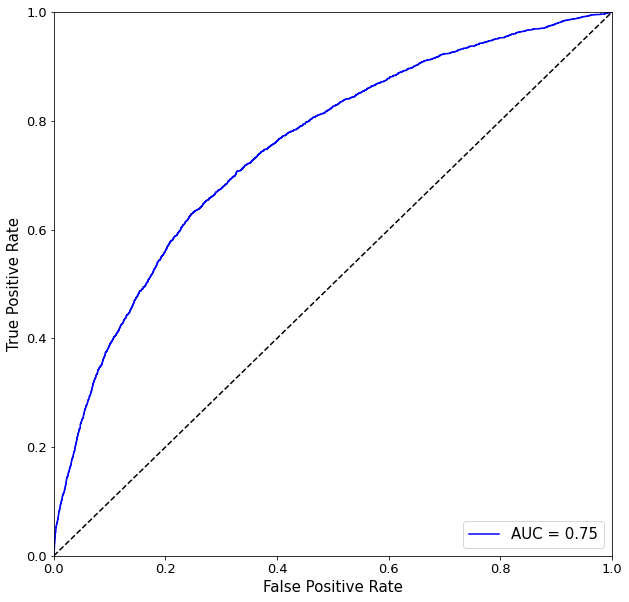

In [23]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgb, pos_label=1)
roc_auc = auc(fpr, tpr) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right', fontsize=15)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tick_params(labelsize=13)
plt.xlabel('False Positive Rate', fontsize=15) 
plt.ylabel('True Positive Rate', fontsize=15)  
plt.savefig('roc.png')

### 7. Feature Importance
- SHAP reference：https://www.kaggle.com/dansbecker/shap-values

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

from xgboost import XGBClassifier
xgb = XGBClassifier(nthread=2, seed=0, subsample=0.4, scale_pos_weight=3, reg_lambda=0.0001, reg_alpha=1e-09, 
                    n_estimators=100, min_child_weight=1, max_depth=2, learning_rate=0.1, gamma=1.0, 
                    colsample_bytree=0.8)
xgb.fit(X_train.values, y_train.values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, nthread=2, num_parallel_tree=1,
              random_state=0, reg_alpha=1e-09, reg_lambda=0.0001,
              scale_pos_weight=3, seed=0, subsample=0.4, tree_method='exact',
              validate_parameters=1, verbosity=None)

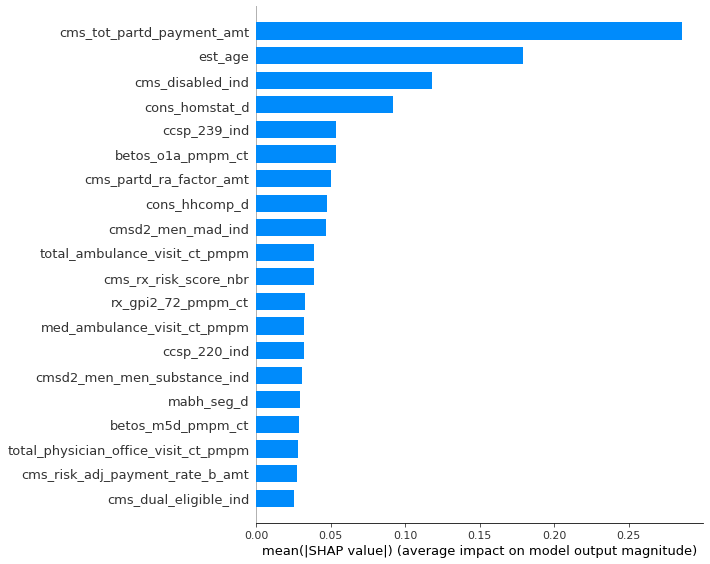

In [57]:
import shap
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [50]:
top_20 = ['cms_tot_partd_payment_amt',
            'est_age',
            'cms_disabled_ind',
            'cons_homstat_d',
            'ccsp_239_ind',
            'betos_o1a_pmpm_ct',
            'cms_partd_ra_factor_amt',
            'cons_hhcomp_d',
            'cmsd2_men_mad_ind',
            'total_ambulance_visit_ct_pmpm',
            'cms_rx_risk_score_nbr',
            'rx_gpi2_72_pmpm_ct',
            'med_ambulance_visit_ct_pmpm',
            'ccsp_220_ind',
            'cmsd2_men_men_substance_ind',
            'mabh_seg_d',
            'betos_m5d_pmpm_ct',
            'total_physician_office_visit_ct_pmpm',
            'cms_risk_adj_payment_rate_b_amt',
            'cms_dual_eligible_ind']

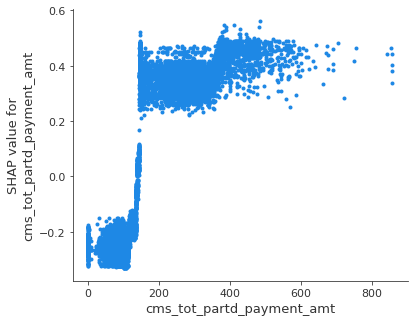

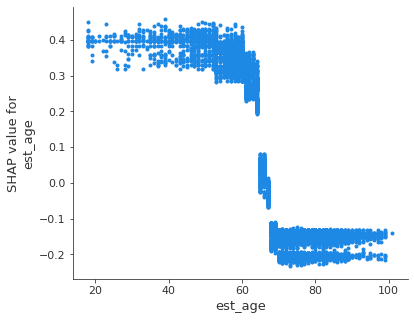

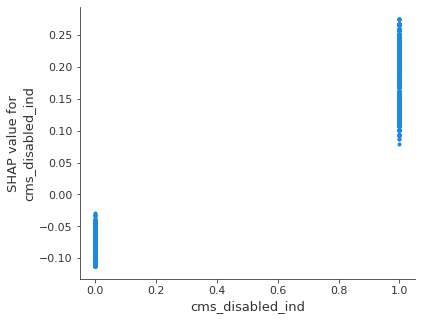

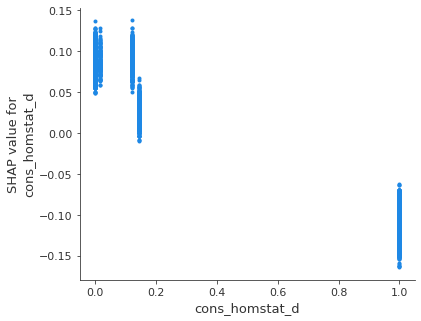

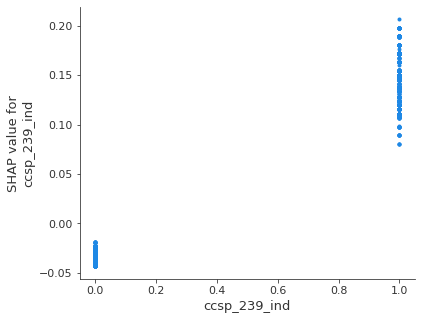

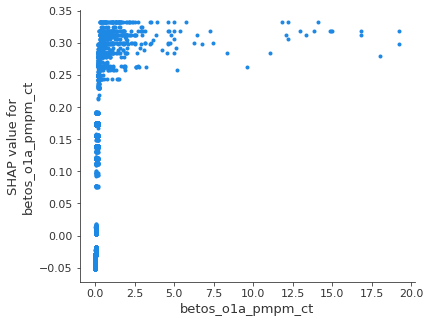

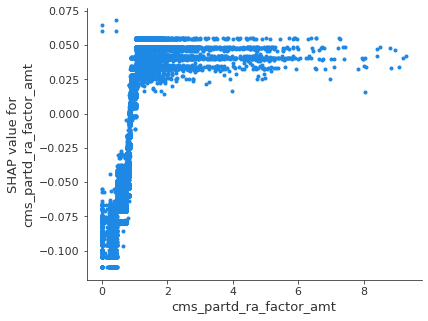

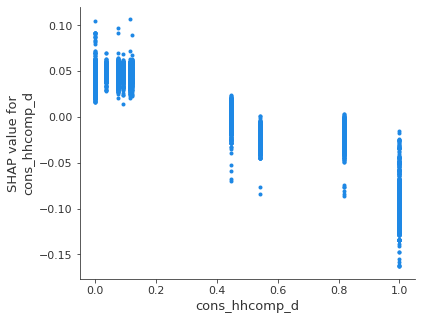

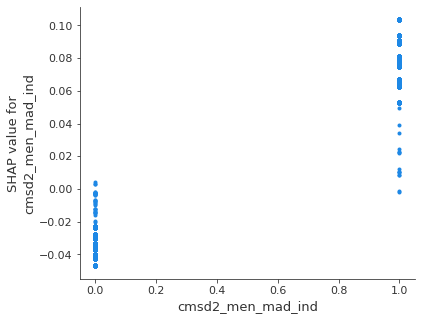

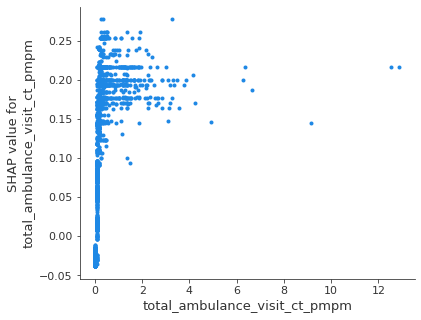

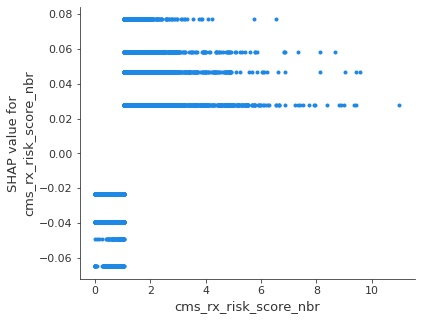

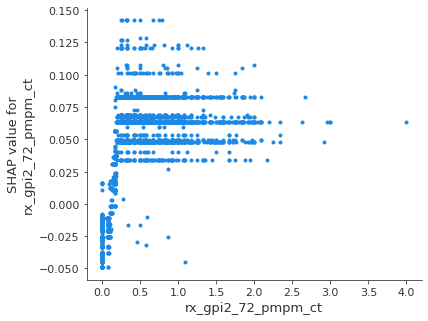

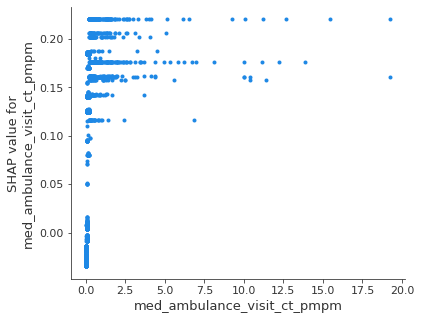

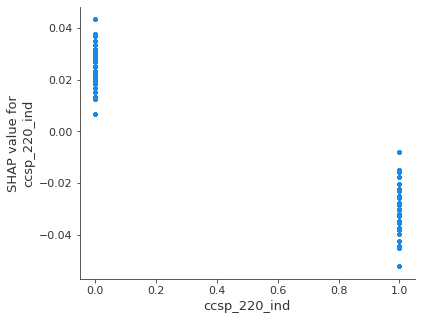

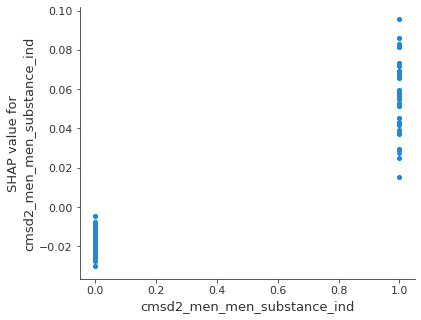

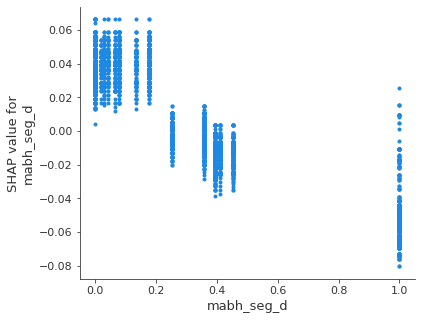

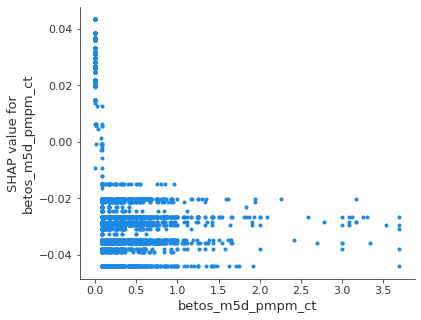

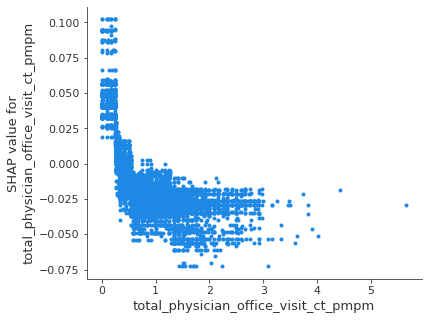

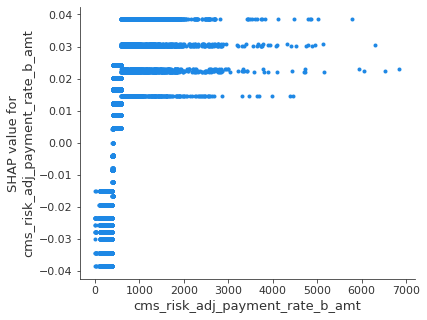

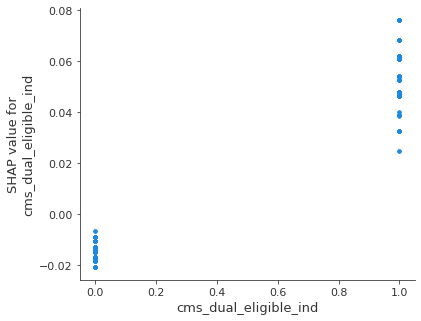

In [58]:
for i in range(len(top_20)):
    shap.dependence_plot(ind = top_20[i],
                         shap_values=shap_values,
                         features = X_test,
                         interaction_index = None)

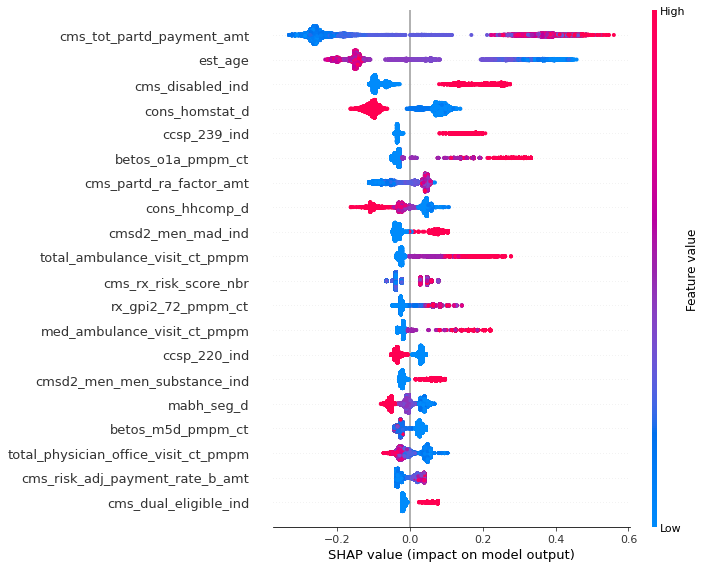

In [9]:
shap.summary_plot(shap_values, X_test, plot_type="dot")

### 8. Prediction

In [52]:
from xgboost import XGBClassifier
xgb = XGBClassifier(nthread=2, seed=0, subsample=0.4, scale_pos_weight=3, reg_lambda=0.0001, reg_alpha=1e-09, 
                    n_estimators=100, min_child_weight=1, max_depth=2, learning_rate=0.1, gamma=1.0, 
                    colsample_bytree=0.8)
xgb.fit(X, y)

# Store the model
# import joblib
# joblib.dump(xgb, "xgb.m")

# Load the model
# import joblib
# xgb = joblib.load("xgb.m")

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, nthread=2, num_parallel_tree=1,
              random_state=0, reg_alpha=1e-09, reg_lambda=0.0001,
              scale_pos_weight=3, seed=0, subsample=0.4, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [53]:
# Load the prepossed holdout data
X = pd.read_csv('processed_holdout_data.csv', index_col='person_id_syn')

In [54]:
import joblib
xgb = joblib.load("xgb.m")
result = pd.DataFrame({'ID':X.index})
result['SCORE'] = xgb.predict_proba(X)[:,1]
result = result.sort_values(by='SCORE', ascending=False)
result['RANK'] = result.SCORE.rank(method='dense',ascending=False).astype(int)
result.reset_index(inplace=True, drop=True)
result.head()

,ID,SCORE,RANK
0,292eM5OSTbL8YA9b4Ib4ecd1,0.913511,1
1,69aMO3eedc5STLaYA2b2Ia15,0.907402,2
2,6fMO9ST1dLa734Yf34Ab1fIf,0.904137,3
3,MO06S57eTcec1ddeL060YA2I,0.902900,4
4,857a37cMd3OcSTfb1LaYcAbI,0.902730,5


0.15762683106159153


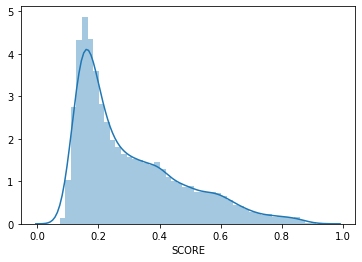

In [55]:
print((result.SCORE>0.5).mean())
sns.distplot(result['SCORE'])